# Мобильные приложения

**Цель исследования:**

- Определить поведение пользователей приложения на основе метрик


**Обзор данных (датасет содержит данные о событиях, совершенных в мобильном приложении для продажи вещей "Ненужные вещи" после 7 октября 2019 года):**

+ event.time — время совершения
+ event.name — название события
+ user.id — идентификатор пользователя
+ userId — идентификатор пользователя
+ source — источник, с которого пользователь установил приложение
+ advert_open — открытие карточки объявления
+ photos_show — просмотр фотографий в объявлении
+ tips_show — пользователь увидел рекомендованные объявления
+ tips_click — пользователь кликнул по рекомендованному объявлению
+ contacts_show и show_contacts — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
+ contacts_call — пользователь позвонил по номеру телефона на карточке объявления
+ map — пользователь открыл карту размещенных объявлений
+ search_1 — search_7 — разные события, связанные с поиском по сайту
+ favorites_add — добавление объявления в избранное

## 1. Обзор данных

### 1.1 Выгрузка и описание

In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy as np
import math as mth
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

/Users/yusuf/opt/anaconda3/envs/praktikum_env_macos2/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('max_colwidth', 400)
pd.set_option('display.precision',2)
sns.set(rc={'figure.figsize':(16, 7)})

In [5]:
dataset = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/mobile_dataset.csv')
sources = pd.read_csv('/Users/yusuf/Desktop/Programming/Projects/Data/mobile_sourсes.csv')

In [6]:
dataset.head()

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [8]:
print('Количество дубликатов в данных dataset:', dataset.duplicated().sum())

Количество дубликатов в данных dataset: 0


In [9]:
sources.head()

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

In [10]:
sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [11]:
print('Количество дубликатов в данных sources:', sources.duplicated().sum())

Количество дубликатов в данных sources: 0


### 1.2 Предобработка

In [12]:
dataset.columns = ['event_time', 'event_name', 'user_id']
sources.columns = ['user_id', 'source']

In [13]:
dataset['event_time'] = pd.to_datetime(dataset['event_time'], format='%Y-%m-%d %H:%M:%S')
dataset['event_date'] = pd.to_datetime(dataset['event_time'].dt.date, format='%Y-%m-%d')

## 2. Исследовательский анализ

### 2.1 Расчет метрик

#### 2.1.1 Количество событий на дату

In [14]:
events_by_date = (dataset.groupby('event_date').agg({'user_id':'count'})
                  .rename(columns={'user_id': 'n_events'}).reset_index())

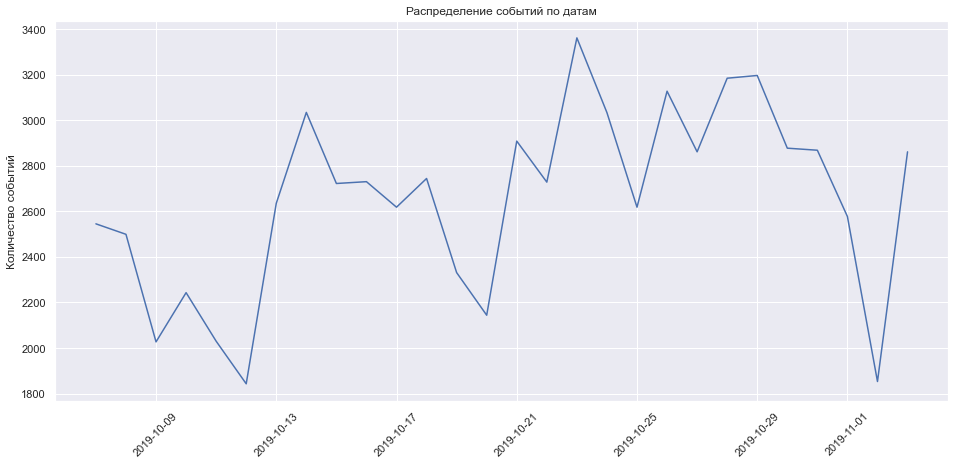

In [15]:
plt.plot(events_by_date['event_date'], events_by_date['n_events'])
plt.title('Распределение событий по датам')
plt.ylabel('Количество событий')
plt.xticks(rotation=45);

Нельзя выделить какую-то закономерность или аномалию, так как количество событий регулярно чередуются от низких к пиковым. В даты отсутствуют крупные праздники, после которых люди могут продавать свои подарки или перед которыми люди наоборот бы их искали

#### 2.1.2 Retention Rate

In [16]:
first_event_date = dataset.groupby(['user_id'])['event_date'].min()
first_event_date.name = 'first_event_date'

In [17]:
events_with_first_date = dataset.join(first_event_date, on='user_id')

In [18]:
events_with_first_date['event_week'] = (pd.to_datetime(events_with_first_date['event_date'], unit='d') - 
                                        pd.to_timedelta(events_with_first_date['event_date'].dt.dayofweek, unit='d'))
events_with_first_date['first_event_week'] = (pd.to_datetime(events_with_first_date['first_event_date'], unit='d') - 
                                              pd.to_timedelta(events_with_first_date['first_event_date'].dt.dayofweek, unit='d'))

In [19]:
events_with_first_date['cohort_lifetime'] = (events_with_first_date['event_week'] - 
                                             events_with_first_date['first_event_week'])
events_with_first_date['cohort_lifetime'] = events_with_first_date['cohort_lifetime'] / np.timedelta64(1,'W')
events_with_first_date['cohort_lifetime'] = events_with_first_date['cohort_lifetime'].astype('int')

In [20]:
cohorts = (events_with_first_date.groupby(['first_event_week','cohort_lifetime']).agg({'user_id': 'nunique'})
           .rename(columns={'user_id': 'n_users'}).reset_index())

In [21]:
initial_users_count = (cohorts[cohorts['cohort_lifetime'] == 0][['first_event_week', 'n_users']]
                       .rename(columns={'n_users':'cohort_users'}))
initial_users_count

first_event_week  cohort_users
0       2019-10-07          1130
4       2019-10-14          1166
7       2019-10-21          1094
9       2019-10-28           903

За месяц количество пользователей снизилось

In [22]:
cohorts = cohorts.merge(initial_users_count, on='first_event_week')

In [23]:
cohorts['retention'] = cohorts['n_users'] / cohorts['cohort_users']

In [24]:
retention_pivot = cohorts.pivot_table(index='first_event_week', columns='cohort_lifetime', values='retention',
                                      aggfunc='sum')

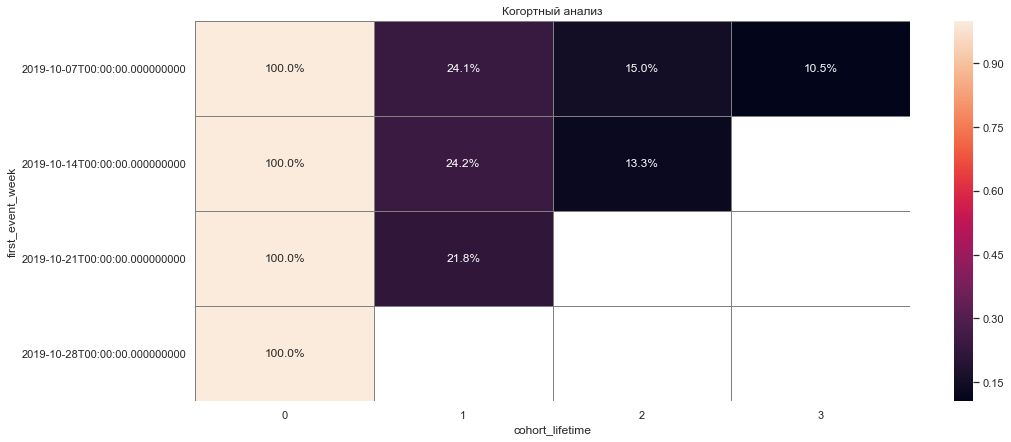

In [25]:
sns.set(style='white')
plt.title('Когортный анализ')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Коэффициент удержания также падает

#### 2.1.3 Количество сессий на одного пользователя

In [26]:
all_users_ts = dataset.groupby('user_id').agg({'event_time': 'unique'}).reset_index()

In [27]:
for i in range(0, len(all_users_ts)):
    row = all_users_ts.loc[i,'event_time']
    count = 0
    for j in range(1, len(row)):
        time_interval = int(((pd.to_datetime(row[j], format='%Y-%m-%d %H:%M:%S') - 
                          pd.to_datetime(row[j-1], format='%Y-%m-%d %H:%M:%S')) / np.timedelta64(1,'m')))
        if time_interval > 30:
            count +=1
        else:
            continue
    if count == 0:
        if len(row) > 1:
            count = 1
        else:
            count = 0
    all_users_ts.loc[i,'n_sessions'] = count

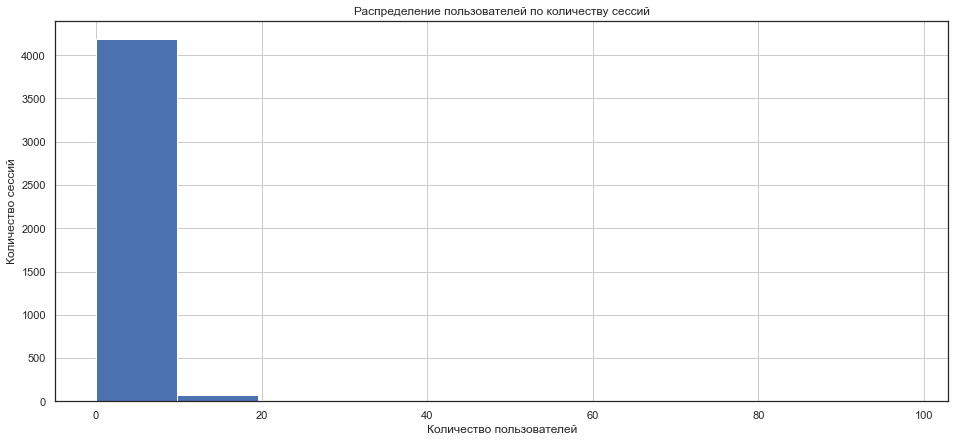

In [28]:
all_users_ts['n_sessions'].hist()
plt.xlabel('Количество пользователей')
plt.ylabel('Количество сессий')
plt.title('Распределение пользователей по количеству сессий');

In [29]:
all_users_ts['n_sessions'].describe()

count    4293.00
mean        1.93
std         3.35
min         0.00
25%         1.00
50%         1.00
75%         2.00
max        98.00
Name: n_sessions, dtype: float64

Большинство пользователей совершили лишь один вход в приложение

#### 2.1.4 Количество совершенных действий

In [30]:
events_by_user = (dataset.groupby(['event_date', 'user_id']).agg({'event_name': 'count'})
                  .rename(columns={'event_name':'event_count'}).reset_index())

In [31]:
mean_events_by_user = (events_by_user.groupby('user_id').agg({'event_count': 'mean'})
                       .rename(columns={'event_count':'event_mean'}).reset_index())

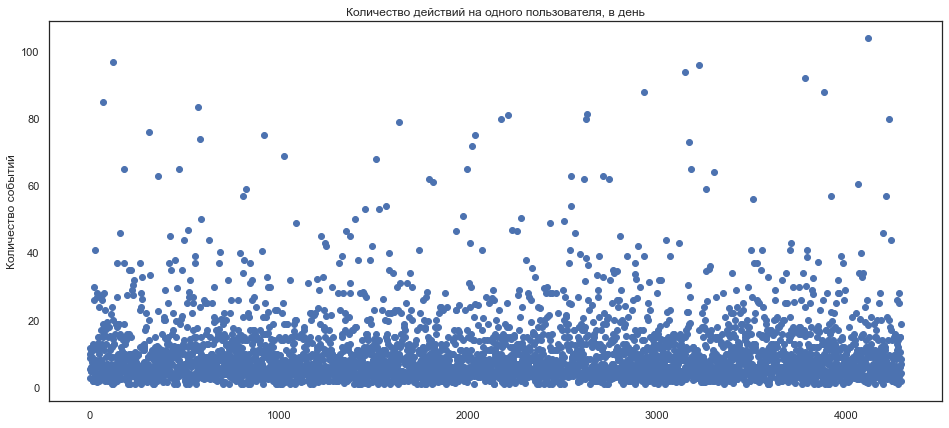

In [32]:
x_values = pd.Series(range(0,len(mean_events_by_user)))
plt.scatter(x_values, mean_events_by_user['event_mean'])
plt.ylabel('Количество событий')
plt.title('Количество действий на одного пользователя, в день');

Большинство пользователей совершают от 1 до 17 действий в день

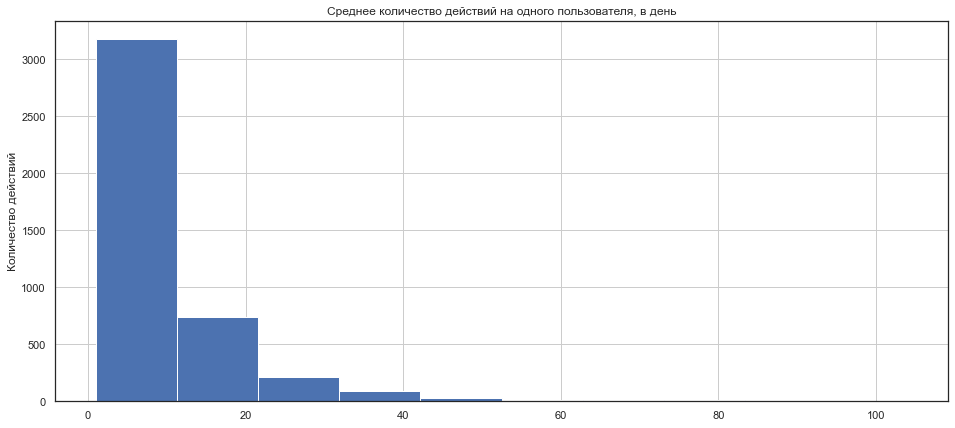

In [33]:
mean_events_by_user['event_mean'].hist()
plt.ylabel('Количество действий')
plt.title('Среднее количество действий на одного пользователя, в день');

In [34]:
mean_events_by_user['event_mean'].describe()

count    4293.00
mean        9.87
std        10.16
min         1.00
25%         4.00
50%         7.00
75%        12.00
max       104.00
Name: event_mean, dtype: float64

В среднем пользователи совершают 10 действий в день

### 2.2 Сегментация пользователей

#### 2.2.1 На основе времени прихода в приложение

In [35]:
conversion_by_cohort = (events_with_first_date.groupby(['first_event_week', 'event_name']).agg({'user_id':'nunique'})
                        .rename(columns={'user_id': 'n_users'}).reset_index())

In [36]:
conversion_by_cohort = conversion_by_cohort.merge(initial_users_count, on='first_event_week')
conversion_by_cohort['conversion_rate'] = (conversion_by_cohort['n_users'] / conversion_by_cohort['cohort_users']).round(2)

In [37]:
conversion_by_cohort.query('event_name == "contacts_show"')

first_event_week     event_name  n_users  cohort_users  conversion_rate
2        2019-10-07  contacts_show      272          1130             0.24
18       2019-10-14  contacts_show      253          1166             0.22
34       2019-10-21  contacts_show      267          1094             0.24
50       2019-10-28  contacts_show      187           903             0.21

Разница в конверсии между когортами минимальна

#### 2.2.2 На основе использования поиска

In [38]:
search_list=['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']

users_search = dataset.query('event_name.isin(@search_list)')['user_id'].drop_duplicates().reset_index()
users_search_list = list(users_search['user_id'])

users_no_search = dataset.query('user_id not in @users_search_list')['user_id'].drop_duplicates().reset_index()
users_no_search_list = list(users_no_search['user_id'])

In [39]:
print('Количество пользователей использующих поиск:', len(users_search))

Количество пользователей использующих поиск: 1666


In [40]:
print('Количество пользователей не использующих поиск:', len(users_no_search))

Количество пользователей не использующих поиск: 2627


In [41]:
search_conversion = (dataset.query('user_id in @users_search_list').groupby('event_name').agg({'user_id': 'nunique'})
                    .rename(columns={'user_id': 'n_users'}).reset_index())
no_search_conversion = (dataset.query('user_id in @users_no_search_list').groupby('event_name')
                        .agg({'user_id': 'nunique'}).rename(columns={'user_id': 'n_users'}).reset_index())

In [42]:
search_conversion['conversion_rate'] = (search_conversion['n_users'] / len(users_search)).round(2)
no_search_conversion['conversion_rate'] = (no_search_conversion['n_users'] / len(users_no_search)).round(2)

In [43]:
conversion_compare = pd.concat([search_conversion.query('event_name == "contacts_show"'), 
                                no_search_conversion.query('event_name == "contacts_show"')]).reset_index(drop=True)
conversion_compare

event_name  n_users  conversion_rate
0  contacts_show      377             0.23
1  contacts_show      602             0.23

Разница в конверсии отсутствует

In [44]:
def create_user_lists_by_conditions(conditions_list, dataset):
    
    user_groups_list = []
    for condition in conditions_list:
        group = dataset.query(condition)['user_id'].drop_duplicates().reset_index()
        group_list = list(group['user_id'])
        user_groups_list.append(group_list)
    
    return user_groups_list

In [45]:
def create_conversion_df(user_groups_list):
    
    group_conversion_dfs = []
    
    for user_group in user_groups_list:
        group_conversion = (dataset.query('user_id in @user_group').groupby('event_name')
                         .agg({'user_id': 'nunique'}).rename(columns={'user_id': 'n_users'}).reset_index())
        group_conversion['total_users'] = len(user_group)
        group_conversion['conversion_rate'] = (group_conversion['n_users'] / group_conversion['total_users']).round(2)
        group_conversion = group_conversion.query('event_name == "contacts_show"')
        group_conversion_dfs.append(group_conversion)
        
    return group_conversion_dfs

In [46]:
def compare_conversion_df(dfs_as_list):
    conversion_compare = pd.concat(dfs_as_list).reset_index(drop=True)
    return conversion_compare

In [47]:
def full_conversion_func(users_groups_list):
    group_conversion_dfs = create_conversion_df(users_groups_list)
    conversion_compare_df = compare_conversion_df(group_conversion_dfs)
    return conversion_compare_df

In [48]:
def build_retention_plot(group_list, title):
    
    events_with_first_date_cut = events_with_first_date.query('user_id.isin(@group_list)')
    
    cohorts = (events_with_first_date_cut.groupby(['first_event_week','cohort_lifetime']).agg({'user_id':'nunique'})
               .rename(columns={'user_id': 'n_users'}).reset_index())
    
    initial_users_count = (cohorts[cohorts['cohort_lifetime'] == 0][['first_event_week','n_users']]
                           .rename(columns={'n_users':'cohort_users'}))
    
    cohorts = cohorts.merge(initial_users_count, on='first_event_week')
    
    cohorts['retention'] = cohorts['n_users']/cohorts['cohort_users']
    
    retention_pivot = cohorts.pivot_table(index='first_event_week',columns='cohort_lifetime',values='retention',
                                          aggfunc='sum')
    
    sns.set(style='white')
    plt.title(title)
    sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

#### 2.2.3 На основе добавления в "избранное"

In [49]:
favorites_add_groups = create_user_lists_by_conditions(['event_name == "favorites_add"', 
                                                        'user_id not in @user_groups_list[0]'], dataset)

full_conversion_func(favorites_add_groups)

event_name  n_users  total_users  conversion_rate
0  contacts_show      136          351             0.39
1  contacts_show      843         3942             0.21

Конверсия людей добавляющих объявления в "избранное" на 85% выше, чем у тех, кто не делает этого

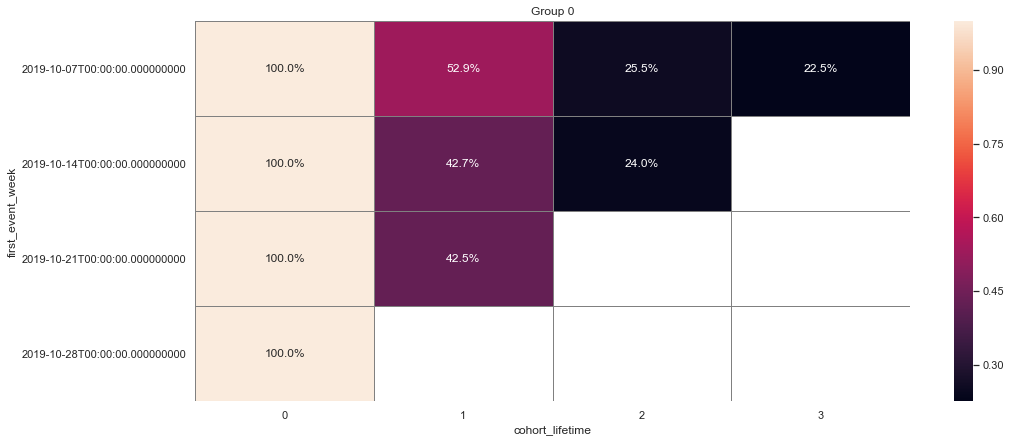

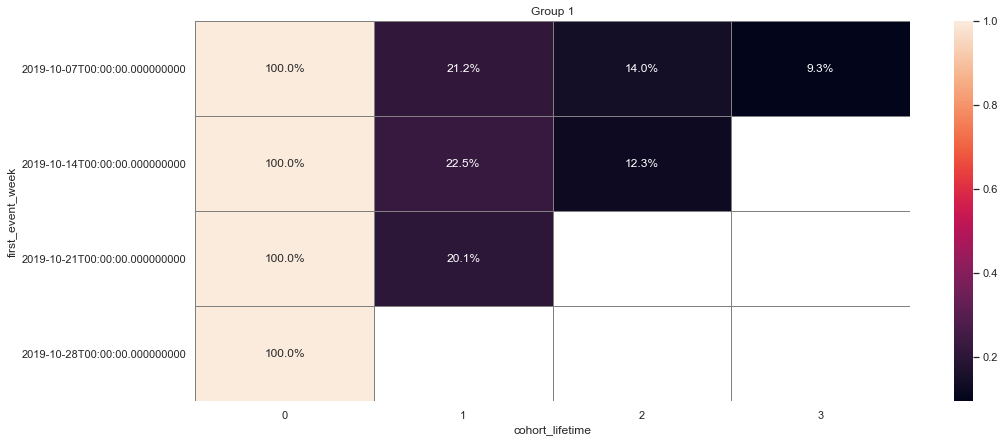

In [50]:
favorite_groups_list = create_user_lists_by_conditions(['event_name == "favorites_add"', 
                                                        'user_id not in @user_groups_list[0]'], dataset)

for group in favorite_groups_list:
    plt.figure()
    build_retention_plot(group, 'Group {}'.format(str(favorite_groups_list.index(group))))

Коэффициент удержания также выше у группы, добавляющей в "избранное", что логично, так как добавление в "избранное" увеличивает вероятность покупки товара. При этом удержание в обоих группах сильно падает со временем

In [51]:
def build_comparison_hists_mean_events(groups_user_list, title_1):
    hist_data = ([mean_events_by_user.query('user_id in @groups_user_list[1]')['event_mean'],
                  mean_events_by_user.query('user_id in @groups_user_list[0]')['event_mean']])
    group_labels = ['others', title_1]
    fig = ff.create_distplot(hist_data, group_labels, bin_size=1, show_rug=False)
    fig.update_layout(title_text='Среднее количество действий в день, на пользователя')
    fig.show()

In [52]:
build_comparison_hists_mean_events(favorite_groups_list, 'favorites_add')

По среднему количеству действий данные группы практически не различаются - люди добавляющие в "избранное" совершают чуть больше действий, что логично

In [53]:
def build_comparison_hists_sessions(groups_user_list, title_1):
    hist_data = ([all_users_ts.query('user_id in @groups_user_list[1]')['n_sessions'],
             all_users_ts.query('user_id in @groups_user_list[0]')['n_sessions']])
    group_labels = ['others', title_1]
    fig = ff.create_distplot(hist_data, group_labels, bin_size=1, show_rug=False)
    fig.update_layout(title_text='Количество сессий за месяц, на пользователя')
    fig.show()

In [54]:
build_comparison_hists_sessions(favorite_groups_list, 'favorites_add')

Количество сессий также практически идентично, также немного выбиваются те, кто используют "избранное" - больше людей заходящих по 10 раз в приложение, скорее всего они проверяют добавленный в "избранное" товар

#### 2.2.4 На основе использования "рекомендаций"

In [55]:
tips_clisk_groups = create_user_lists_by_conditions(['event_name == "tips_click"', 'user_id not in @user_groups_list[0]'], 
                                                    dataset)
full_conversion_func(tips_clisk_groups)

event_name  n_users  total_users  conversion_rate
0  contacts_show      100          322             0.31
1  contacts_show      879         3971             0.22

Конверсия пользователей пользующихся "рекомендациями" на 41% выше. Рекомендации хорошо работают, но до них нужно дойти

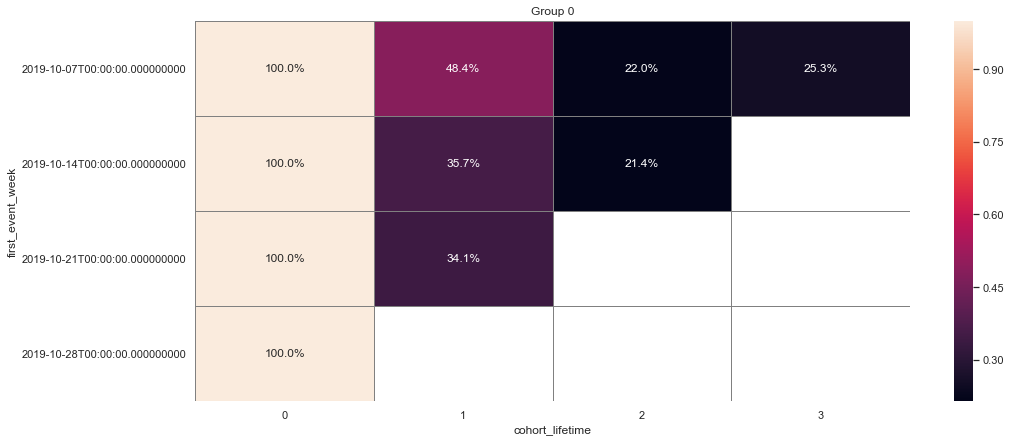

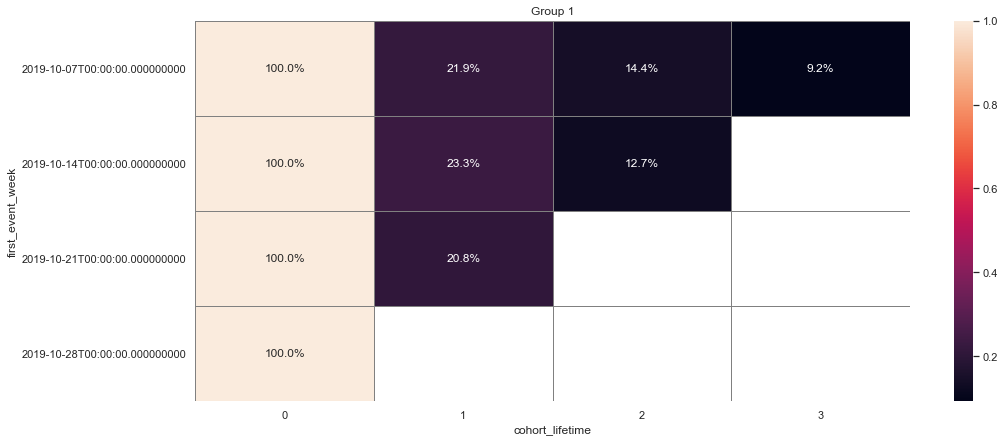

In [56]:
for group in tips_clisk_groups:
    plt.figure()
    build_retention_plot(group, 'Group {}'.format(str(tips_clisk_groups.index(group))))

Тоже самое заметно по коэффициенту удержания - рекомендации затягивают пользователей. Тем не менее удержание сильно падает после первой недели - возможно рекомендации редко обновляются

In [57]:
build_comparison_hists_mean_events(tips_clisk_groups, 'tips_click')

Пользователи "рекомендаций" совершают больше действий за день - логично

In [58]:
build_comparison_hists_sessions(tips_clisk_groups, 'tips_click')

При этом количество сессий отличается не так сильно - то есть возможно рекомендации действительно обновляются редко, пользователь быстро это понимает и перестаёт их проверять

#### 2.2.5 На основе просмотра изображений

In [59]:
photos_show_groups =  create_user_lists_by_conditions(['event_name == "photos_show"', 'user_id not in @user_groups_list[0]'], 
                                                    dataset)
full_conversion_func(photos_show_groups)

event_name  n_users  total_users  conversion_rate
0  contacts_show      339         1095             0.31
1  contacts_show      640         3198             0.20

Конверсия пользователей просматривающих изображения на 55% выше - то есть нужно стимулировать добавлять изображения к объявлениям, при этом сделать клик по ним еще проще

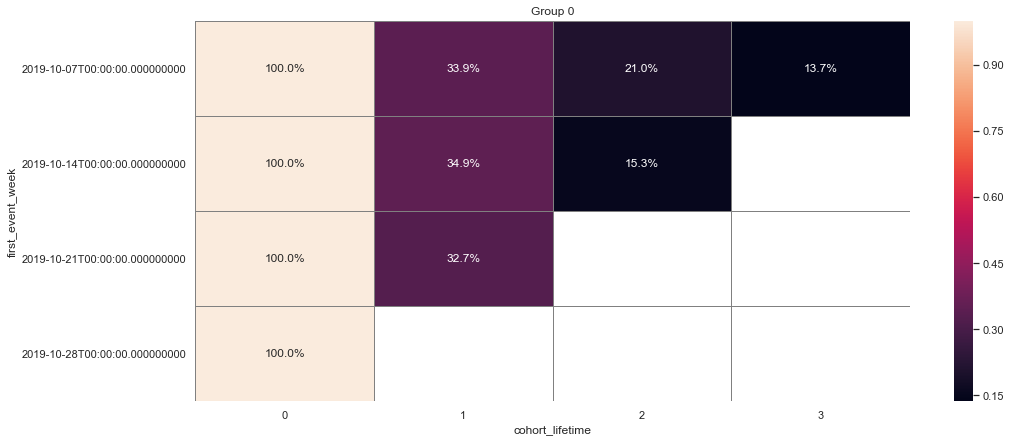

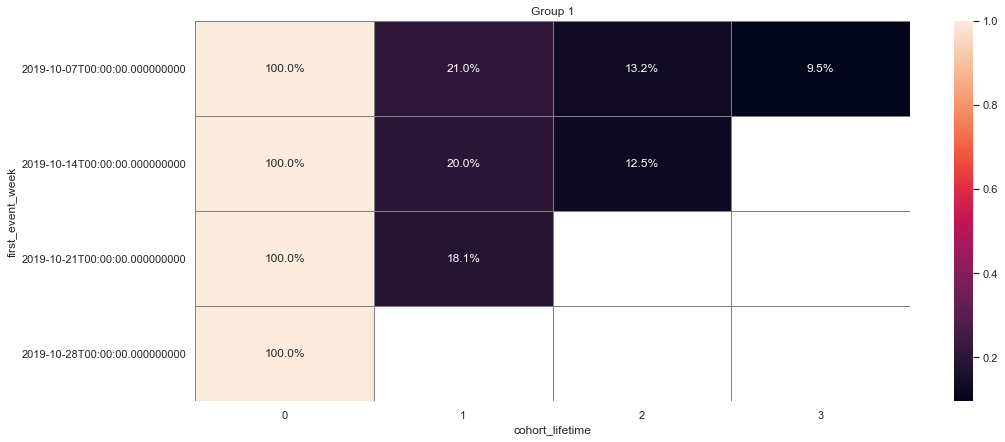

In [60]:
for group in photos_show_groups:
    plt.figure()
    build_retention_plot(group, 'Group {}'.format(str(photos_show_groups.index(group))))

Коэффициент удержания также выше, при этом падение от недели к неделе не столь драматичное, но оно присутствует

In [61]:
build_comparison_hists_mean_events(photos_show_groups, 'photos_show')

Еще одно логичное замечание - пользователи просматривающие фотографии совершают больше действий

In [62]:
build_comparison_hists_sessions(photos_show_groups, 'photos_show')

Так же мало сессий за месяц в обоих группах - в основном 1

#### 2.2.6 На основе использование "карты"

In [63]:
map_groups =  create_user_lists_by_conditions(['event_name == "map"', 'user_id not in @user_groups_list[0]'], 
                                                    dataset)
full_conversion_func(map_groups)

event_name  n_users  total_users  conversion_rate
0  contacts_show      289         1456             0.20
1  contacts_show      690         2837             0.24

Конверсия пользователей использующих карту на 20% ниже - видимо она не оптимизирована в приложении, не очень удобна в использовании

### 2.3 Проверка гипотез

#### 2.3.1 Гипотеза о влиянии сервиса (Яндекс, Google)

**Гипотезы (уровень значимости 5%)**
+ Н0: Конверсия пользователей, установивших приложение через сервис Яндекс, имеет статистически незначимые различия с конверсией пользователей, установивших приложение через сервис Google
+ Н1: Конверсия пользователей, установивших приложение через сервис Яндекс, не имеет статистически незначимых различий с конверсией пользователей, установивших приложение через сервис Google

In [64]:
data_with_sources = dataset.merge(sources, on='user_id')

In [65]:
google_yandex_users_list = create_user_lists_by_conditions(['source == "google"', 'source == "yandex"'], 
                                                             data_with_sources)
full_conversion_func(google_yandex_users_list)

event_name  n_users  total_users  conversion_rate
0  contacts_show      275         1129             0.24
1  contacts_show      478         1934             0.25

In [66]:
successes = np.array([275, 478])
trials = np.array([len(google_yandex_users_list[0]), len(google_yandex_users_list[1])])

p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]
    
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2
    
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
print('Z = ',z_value)

distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

alpha = 0.05

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: конверсия имеет значимую разницу")
else:
    print("Не удалось отвергнуть нулевую гипотезу: конверсия не имеет значимой разницы")

Z =  -0.2218487822311678
p-значение:  0.8244316027993777
Не удалось отвергнуть нулевую гипотезу: конверсия не имеет значимой разницы


#### 2.3.2 Гипотеза о влиянии фотографий 

**Гипотезы (уровень значимости 5%)**
+ Н0: Конверсия пользователей, просматривающих фотографии объявлений, имеет статистически незначимые различия с конверсией пользователей, не просматривающих фотографии объявлений
+ Н1: Конверсия пользователей, просматривающих фотографии объявлений, не имеет статистически незначимых различий с конверсией пользователей, не просматривающих фотографии объявлений

In [67]:
full_conversion_func(photos_show_groups)

event_name  n_users  total_users  conversion_rate
0  contacts_show      339         1095             0.31
1  contacts_show      640         3198             0.20

In [68]:
successes = np.array([339, 640])
trials = np.array([len(photos_show_groups[0]), len(photos_show_groups[1])])

p1 = successes[0]/trials[0]
p2 = successes[1]/trials[1]
    
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
difference = p1 - p2
    
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
print('Z = ',z_value)

distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

alpha = 0.05

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: конверсия имеет значимую разницу")
else:
    print("Не удалось отвергнуть нулевую гипотезу: конверсия не имеет значимой разницы")

Z =  7.451270032685682
p-значение:  9.237055564881302e-14
Отвергаем нулевую гипотезу: конверсия имеет значимую разницу


Фотографии действительно влияют на конверсию пользователей

## 3. Выводы

+ Количество пользователей снижается.
+ Коэффициент удержания также снижается.
+ Различий в конверсии между источниками скачивания (Google и Yandex) не найдено.
+ Большинство пользователей совершили разовый вход в приложение - стоит поработать над интерфейсом.
+ Стоит переработать "карты", так как там ниже конверсия - скорее всего они сильно отталкивают пользователей.
+ Нужно стимулировать продавцов добавлять фотографии.
+ Скорее всего раздел "рекомендаций" обновляется слишком редко, нужно проверить это.